In [1]:
import RNA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from Bio.Seq import Seq
from Bio import motifs
import random

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D


%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'

Using TensorFlow backend.


## Build Encoding Functions Etc

In [2]:
def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))   #LAE: .values added, pd deprecation
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

#### One-Hot Encode Base Pairs (Author Model)

In [3]:
def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

#### Make ORF vectors

In [4]:
START = 'ATG'
STOPS = ['TAA','TGA','TAG']

def orf_vector_encode(df,col='utr',seq_len=50):
    # create empty matrix. Three vectors per sequence b/c one for each open reading frame
    vectors = np.zeros([len(df),seq_len,3]) #the final shape we want
    
    for i,seq in enumerate(df[col].str[:seq_len]):
        vector = np.zeros([3,seq_len]) #hacky thing to get the shape right. This is the array for a single seq.
        seq = seq.upper()
        frame_offsets = [0,1,2] #in-frame, out-of-frame1, out-of-frame2
        for o in frame_offsets:
            #print 'offset', o
            is_orf = seq[o:o+3] == START
            #print seq[o:o+3], is_orf
            for front_ind in range(o,seq_len-(3+(seq_len%3)),3):
                codon = seq[front_ind:front_ind+3]
                if codon in STOPS:
                    is_orf = False
                    vector[o][front_ind:front_ind+3] = [0,0,0]
                else:
                    is_orf = (codon == START) or is_orf
                    vector[o][front_ind:front_ind+3] = [1,1,1] if is_orf else [0,0,0]
                #print codon, is_orf, vectors[i][o][front_ind:front_ind+3]
            #After iterating in sets of 3bp, set any trailing values to 1 if orf hasn't ended
            if (front_ind+3 < seq_len) and (is_orf == True): 
                vector[o][front_ind+3:] = [1]*(seq_len-(front_ind+3)) 
        vectors[i] = vector.transpose()
    return vectors

# This is hella band-aid solution but I can't figure out how to set the info the way I want 
# if I star  in this shape. Maybe I'll figure out a more elegant and efficient solution later.
# def reshape_orf_vectors(vectors):
#     new_vectors = np.zeros((len(vectors),50,3))
#     for i in range(len(vectors)): #length of dataset
#         for j in range(len(new_vectors[0])): #50 bp
#             new_vectors[i][j] = np.array([vectors[i][0][j],vectors[i][1][j],vectors[i][2][j]])
#     return new_vectors
    

#### One-Hot CODON encoding

In [5]:
from itertools import product

codon_d = {}
codon_list = []
keys = product('ACGTN',repeat=3)  
values = np.identity(64) #4 choices to the power of 3 spaces = 64
value_for_n = np.zeros(64)
j = 0
for k in keys:
    if 'N' in k:
        codon_d["".join(k)] = value_for_n
    else:
        codon_d["".join(k)] = values[j]
        codon_list.append("".join(k))
        j += 1


In [6]:
def codon_one_hot_encode(df,col='utr',seq_len=50):
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len/3,64])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.upper()
        codons = [ seq[j:j+3] for j in range(0,seq_len,3) ][:-1] #drop the incomplete last "codon" of 2bp
        a = np.array([codon_d[c] for c in codons])
        vectors[i] = a
    return vectors

### One-Hot Codon Encoding, all three frames combined 
aka, slide *one bp at a time* along the sequence and record the codon. Rather than just the in-frame codons.

In [7]:
def alternate_codon_encode(df,col='utr',seq_len=50):
     # Creat empty matrix.
    vectors=np.empty([len(df),seq_len-3,64]) #end up with 47 codons 
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.upper()
        codons = [ seq[j:j+3] for j in range(0,seq_len-3) ]
        a = np.array([codon_d[c] for c in codons])
        vectors[i] = a
    return vectors

## Data Loading and Preparation

In [8]:
#df = pd.read_pickle('../data/egfp_unmod_1.pkl')  #LAE: do not have this pickle file...?
df = pd.read_csv('../data/egfp_unmod_1.csv')
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df.iloc[:20000] #these are the 20k with the HIGHEST READ COUNT
e_train = df.iloc[20000:]

# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

# ORF Vector encode both training and test UTRs
orf_e_train = orf_vector_encode(e_train)
orf_e_test = orf_vector_encode(e_test)

# Codon one-hot encode both training and test UTRs
co_e_train = codon_one_hot_encode(e_train)
co_e_test = codon_one_hot_encode(e_test)

# Alternate one-hot encoding for both training and test UTRs
altc_e_train = alternate_codon_encode(e_train)
altc_e_test = alternate_codon_encode(e_test)

# Scale the training mean ribosome load values
# LAE: added .values before reshape due to pandas naming deprecation
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

label_e_train = e_train['scaled_rl']
label_e_test = e_test['rl']

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Create and Train Models

In [9]:
def train_model(x, y, border_mode='same', inp_len=50, inp_features=4, nodes=40, 
                layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, inp_features),
                         padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1),
                         padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), 
                         padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model

In [69]:
# Load Models
small_model_bp = keras.models.load_model('./saved_models/10f_bp_CNN_model.hdf5')
small_model_orf = keras.models.load_model('./saved_models/10f_orf_CNN_model.hdf5')
small_model_co = keras.models.load_model('./saved_models/10f_codon_CNN_model.hdf5')
small_model_altc = keras.models.load_model('./saved_models/10f_altcodon_CNN_model.hdf5')

In [70]:
# np.random.seed(1337)
# small_model_bp = train_model(seq_e_train, label_e_train, nb_epoch=3, border_mode='same',
#                     inp_len=50, inp_features=4, nodes=40, layers=3, nbr_filters=10, filter_len=8,
#                     dropout1=0, dropout2=0,dropout3=0.2)

In [71]:
e_test = test_data(df=e_test, model=small_model_bp, obs_col='rl',test_seq=seq_e_test,output_col="10f_bp_pred")
r = r2(e_test['rl'], e_test['10f_bp_pred'])
print 'r-squared = ', r

r-squared =  0.9124975794754216


In [72]:
# np.random.seed(1337)
# small_model_orf = train_model(orf_e_train, label_e_train, nb_epoch=3, border_mode='same',
#                     inp_len=50, inp_features=3, nodes=40, layers=3, nbr_filters=10, filter_len=8,
#                     dropout1=0, dropout2=0,dropout3=0.2)

In [73]:
e_test = test_data(df=e_test, model=small_model_orf, obs_col='rl',test_seq=orf_e_test,output_col="10f_orf_pred")
r = r2(e_test['rl'], e_test['10f_orf_pred'])
print 'r-squared = ', r

r-squared =  0.7541478391805556


In [74]:
# np.random.seed(1337)
# #3 codon filters ~= 8 bp filters, wanted to keep the total amount of sequence seen consistent
# small_model_co = train_model(co_e_train, label_e_train, nb_epoch=3, border_mode='same',
#                     inp_len=16, inp_features=64, nodes=40, layers=3, nbr_filters=10, filter_len=3, 
#                     dropout1=0, dropout2=0,dropout3=0.2)

In [75]:
e_test = test_data(df=e_test, model=small_model_co, obs_col='rl',test_seq=co_e_test,output_col="10f_co_pred")
r = r2(e_test['rl'], e_test['10f_co_pred'])
print 'r-squared = ', r

r-squared =  0.7966131464511722


In [76]:
# np.random.seed(1337)
# #6 codon filters ~= 8 bp filters, because first codon filter sees 3bp, and each next one sees +1 bp. 
# small_model_altc = train_model(altc_e_train, label_e_train, nb_epoch=3, border_mode='same',
#                     inp_len=47, inp_features=64, nodes=40, layers=3, nbr_filters=10, filter_len=6, 
#                     dropout1=0, dropout2=0,dropout3=0.2)

In [77]:
e_test = test_data(df=e_test, model=small_model_altc, obs_col='rl',test_seq=altc_e_test,output_col="10f_altc_pred")
r = r2(e_test['rl'], e_test['10f_altc_pred'])
print 'r-squared = ', r

r-squared =  0.9050494671585275


In [78]:
# Save models
# small_model_bp.save('./saved_models/10f_bp_CNN_model.hdf5')
# small_model_orf.save('./saved_models/10f_orf_CNN_model.hdf5')
# small_model_co.save('./saved_models/10f_codon_CNN_model.hdf5')
# small_model_altc.save('./saved_models/10f_altcodon_CNN_model.hdf5')

## Investigate Filters in Small Models -- What do they Look Like?

### One-Hot BP Encoding Model

Text(0.5,1,'First Filter Visualized')

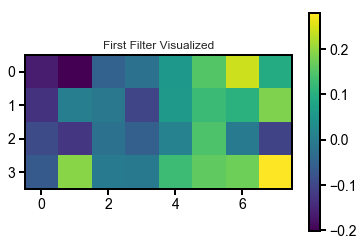

In [20]:
x = small_model_bp.get_weights()
NFILTERS = 10
filters = [x[0][:,:,i] for i in range(NFILTERS)] #layer 1 filters
df_example = pd.DataFrame(data=filters[0])
df_example = df_example.transpose(copy=True)
plt.imshow(df_example,cmap='viridis') #bp position along the bottom, A/T/G/C along y axis
plt.colorbar()
plt.title("First Filter Visualized")

In [21]:
min_weight = np.amin(filters)
max_weight = np.amax(filters)
print 'min', min_weight, 'max', max_weight
A = [ np.array([p[0] for p in f ]) for f in filters ]
C = [ np.array([p[1] for p in f ]) for f in filters ]
G = [ np.array([p[2] for p in f ]) for f in filters ]
T = [ np.array([p[3] for p in f ]) for f in filters ]

min -0.681025 max 0.40408292


In [22]:
def compute_stacked_bot_grid(filterGrid):
    # order: ACGT 0123
    # Note that these comparisons ASSUME that there are no duplicated weights. Probably 
    # this is valid given the number of decimal points involved.
    botGrid = np.zeros(filterGrid.shape)
    for r in range(len(filterGrid)):
        rowValues = filterGrid[r]
        for c,v in enumerate(rowValues):
            colValues = filterGrid[:,c]
            if v < 0: #if value to compute bot for is negative,
                colValues = colValues[(colValues<0)&(colValues!=v)] #keep only the other negative vals in the col
                while len(colValues) > 0:
                    m = np.max(colValues)
                    if v < m:
                        botGrid[r][c] += m
                        colValues = colValues[colValues != m] # down to maximum of 2 other values 
                    else:
                        break
            else: #if value to compute bot for is positive (or zero),
                colValues = colValues[(colValues>0)&(colValues!=v)] #keep only the other positive vals in the col
                while len(colValues) > 0:
                    m = np.min(colValues)
                    if v > m:
                        botGrid[r][c] += m
                        colValues = colValues[colValues != m] # down to maximum of 2 other values
                    else:
                        break
    return botGrid

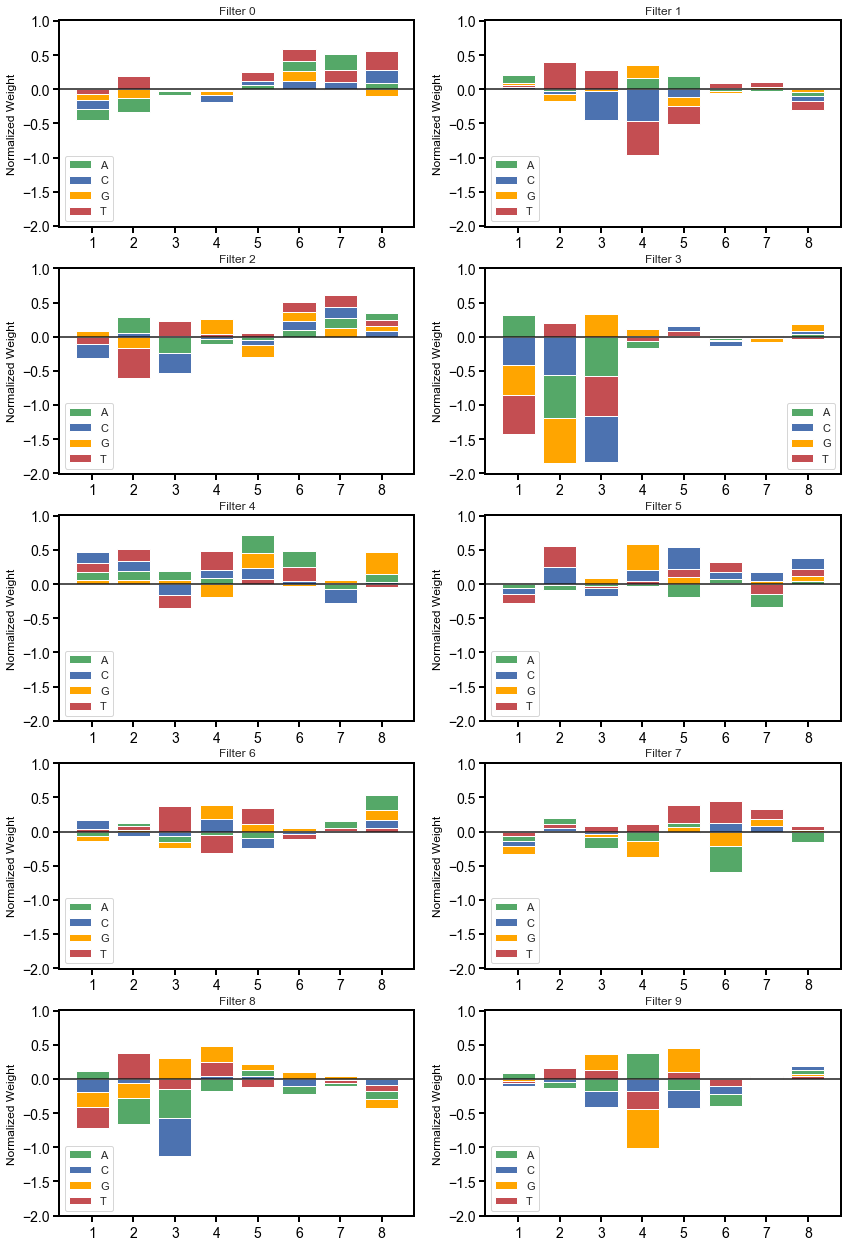

In [23]:
index = np.arange(8) #8 BP WINDOW
fig,axes = plt.subplots(nrows=5,ncols=2,figsize=(14,22)) #TEN FILTERS
for r in range(5):
    for c in range(2):
        i = (r*2) + c
        ax = axes[r][c]
        filterGrid = np.array([A[i],C[i],G[i],T[i]])
        botGrid = compute_stacked_bot_grid(filterGrid)
        # Format so that the negatives and positives don't add together, but stay as independent bars
        pA = ax.bar(index,A[i],width=0.8,color='g',label='A',bottom=botGrid[0])
        pC = ax.bar(index,C[i],width=0.8,color='b',label='C',bottom=botGrid[1])
        pG = ax.bar(index,G[i],width=0.8,color='orange',label='G',bottom=botGrid[2])
        pT = ax.bar(index,T[i],width=0.8,color='r',label='T',bottom=botGrid[3])
        ax.set_xticklabels(['1','2','3','4','5','6','7','8'])
        ax.axhline(y=0,color='k')
        ax.set_xticks(np.arange(8))
        ax.set_ylabel("Normalized Weight")
        ax.set_title("Filter "+str(i))
        ax.set_ylim(-2.01,1.01)
        ax.legend()

done


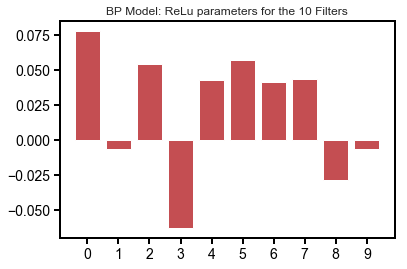

In [24]:
# Which filters have the most negative ReLu Parameters?
plt.bar(range(NFILTERS),x[1],color='r')
plt.title("BP Model: ReLu parameters for the "+str(NFILTERS)+" Filters")
plt.xticks(range(10))
print 'done'

### ORF Vector Encoding Model

Text(0.5,1,'First Filter Visualized')

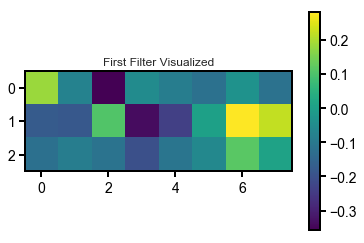

In [25]:
x = small_model_orf.get_weights()
NFILTERS = 10
filters = [x[0][:,:,i] for i in range(NFILTERS)] #layer 1 filters
df_example = pd.DataFrame(data=filters[0])
df_example = df_example.transpose(copy=True)
plt.imshow(df_example,cmap='viridis') #bp position along the bottom, A/T/G/C along y axis
plt.colorbar()
plt.title("First Filter Visualized")

In [26]:
min_weight = np.amin(filters)
max_weight = np.amax(filters)
print 'min', min_weight, 'max', max_weight
I = [ np.array([p[0] for p in f ]) for f in filters ]
O1 = [ np.array([p[1] for p in f ]) for f in filters ]
O2 = [ np.array([p[2] for p in f ]) for f in filters ]

min -0.3887188 max 0.35872978


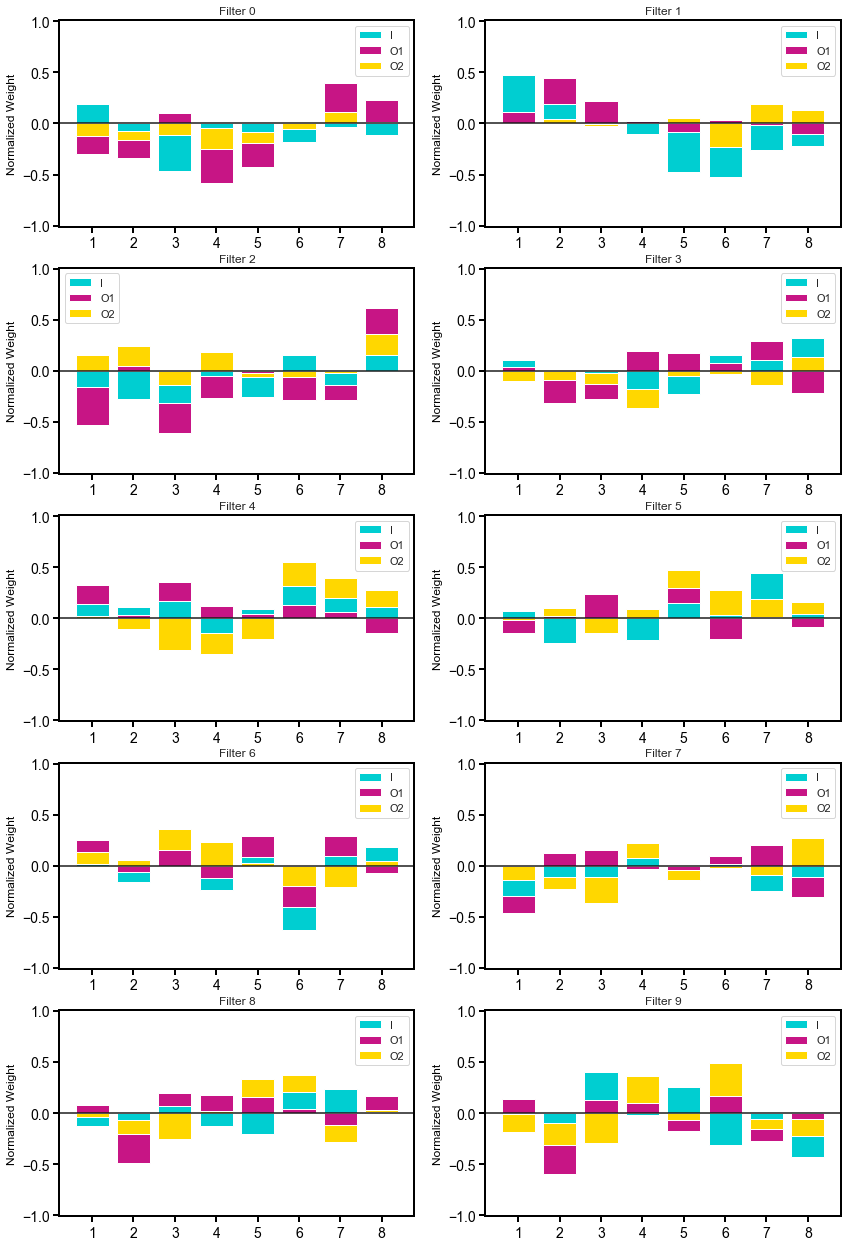

In [27]:
index = np.arange(8) #8 BP WINDOW
fig,axes = plt.subplots(nrows=5,ncols=2,figsize=(14,22)) #TEN FILTERS
for r in range(5):
    for c in range(2):
        i = (r*2) + c
        ax = axes[r][c]
        filterGrid = np.array([I[i],O1[i],O2[i]])
        botGrid = compute_stacked_bot_grid(filterGrid)
        # Format so that the negatives and positives don't add together, but stay as independent bars
        pI = ax.bar(index,I[i],width=0.8,color='darkturquoise',label='I',bottom=botGrid[0])
        pO1 = ax.bar(index,O1[i],width=0.8,color='mediumvioletred',label='O1',bottom=botGrid[1])
        pO2 = ax.bar(index,O2[i],width=0.8,color='gold',label='O2',bottom=botGrid[2])
        ax.set_xticklabels(['1','2','3','4','5','6','7','8'])
        ax.axhline(y=0,color='k')
        ax.set_xticks(np.arange(8))
        ax.set_ylabel("Normalized Weight")
        ax.set_title("Filter "+str(i))
        ax.set_ylim(-1.01,1.01)
        ax.legend()

done


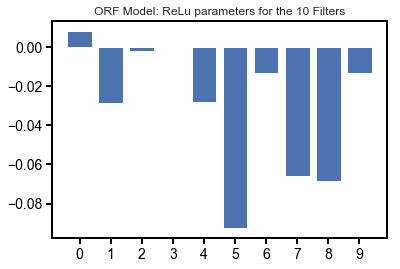

In [28]:
# Which filters have the most negative ReLu Parameters?
plt.bar(range(NFILTERS),x[1],color='b')
plt.title("ORF Model: ReLu parameters for the "+str(NFILTERS)+" Filters")
plt.xticks(range(10))
print 'done'

### One-Hot Codon Encoding Model

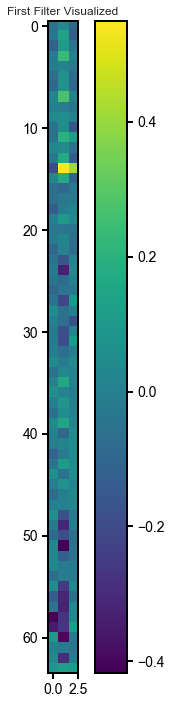

In [29]:
x = small_model_co.get_weights()
NFILTERS = 10
filters = [x[0][:,:,i] for i in range(NFILTERS)] #layer 1 filters
df_example = pd.DataFrame(data=filters[0])
df_example = df_example.transpose(copy=True)
fig,ax = plt.subplots(figsize=(6,12))
im = ax.imshow(df_example,cmap='viridis') #bp position along the bottom, A/T/G/C along y axis
ax.set_title("First Filter Visualized")
plt.colorbar(im,ax=ax)

In [30]:
print 'ATG', codon_list.index('ATG')
print 'TAA', codon_list.index('TAA')
print 'TAG', codon_list.index('TAG')
print 'TGA', codon_list.index('TGA')

ATG 14
TAA 48
TAG 50
TGA 56


In [31]:
import matplotlib
vir = matplotlib.cm.get_cmap('viridis')
colors = [ vir(i) for i in np.linspace(0,1,64) ]
colors[14] = 'mediumvioletred'#start
colors[48] = 'darkgoldenrod' #ochre stop
colors[50] = 'chocolate' #amber stop
colors[56] = 'saddlebrown' #umber stop

In [32]:
min_weight = np.amin(filters)
max_weight = np.amax(filters)
print 'min', min_weight, 'max', max_weight

min -0.55824375 max 0.54941636


so this is a little silly, but here we go


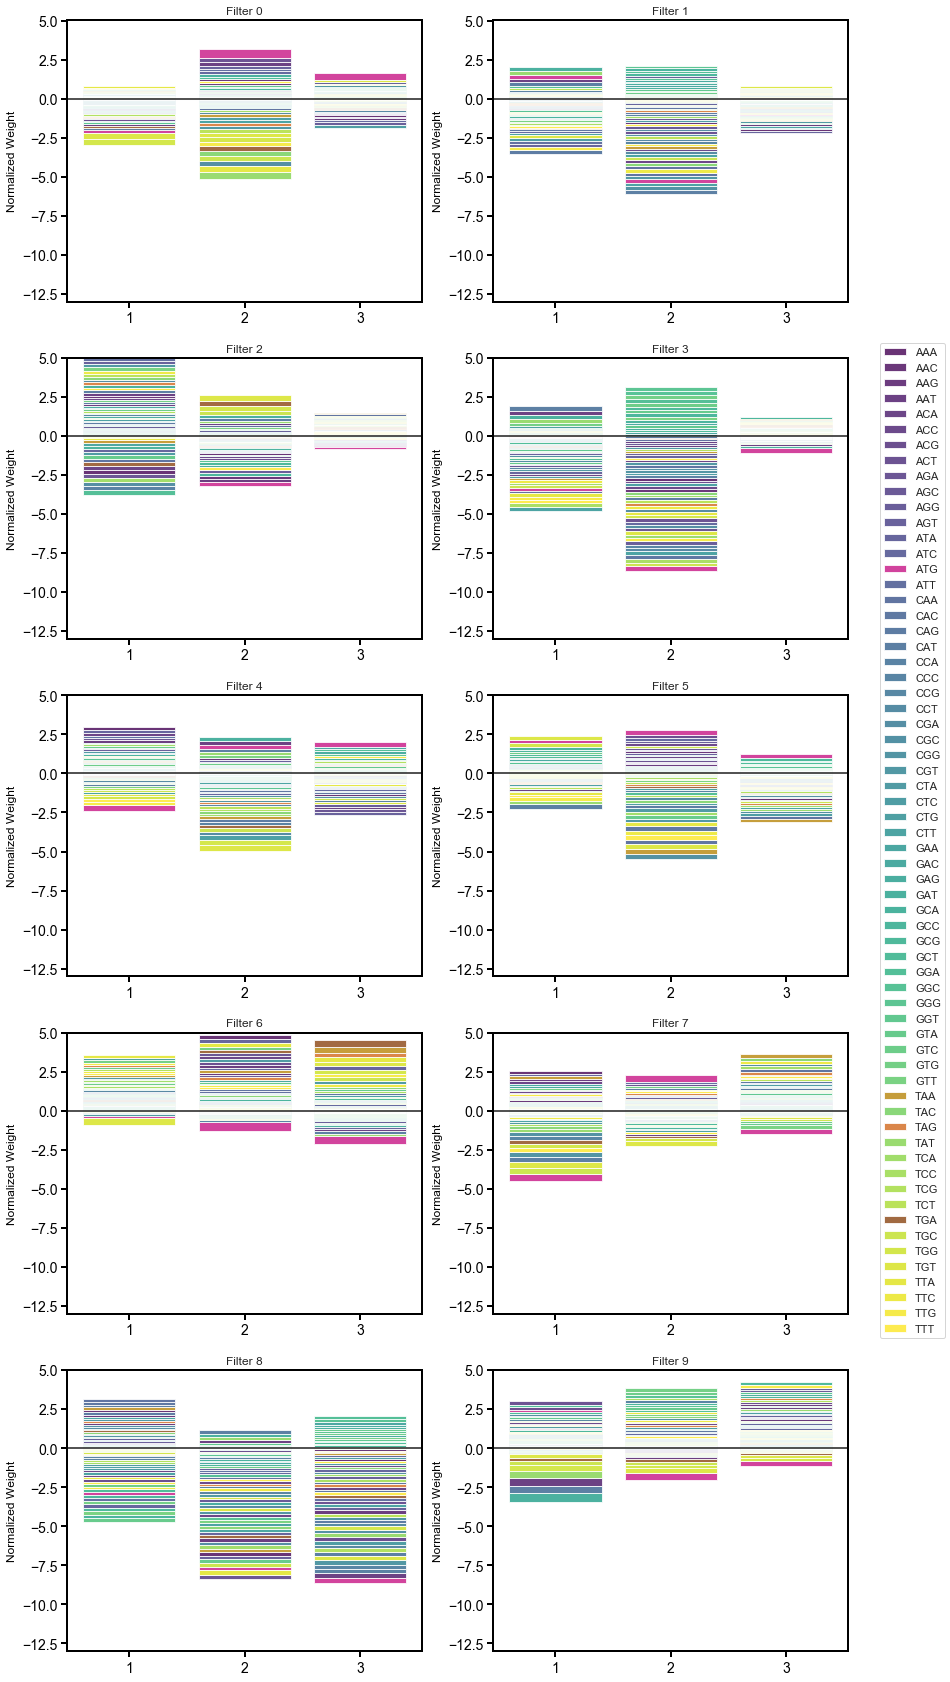

In [33]:
index = np.arange(3) #3 CODON WINDOW
fig,axes = plt.subplots(nrows=5,ncols=2,figsize=(14,30)) #TEN FILTERS
for r in range(5):
    for c in range(2):
        i = (r*2) + c
        ax = axes[r][c]
        filterGrid = filters[i].transpose()
        botGrid = compute_stacked_bot_grid(filterGrid)
        # Format so that the negatives and positives don't add together, but stay as independent bars
        for j in range(64):
            v = filterGrid[j]
            b = botGrid[j]
            im = ax.bar(index,v,width=0.8,color=colors[j],label=codon_list[j],bottom=b,alpha=0.8)
        ax.set_xticklabels(['1','2','3'])
        ax.axhline(y=0,color='k')
        ax.set_xticks(np.arange(3))
        ax.set_ylabel("Normalized Weight")
        ax.set_title("Filter "+str(i))
        ax.set_ylim(-13.01,5.01)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles,labels,loc='right')
print "so this is a little silly, but here we go"

done


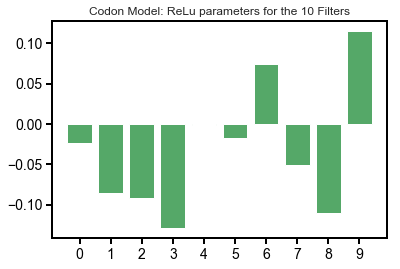

In [34]:
# Which filters have the most negative ReLu Parameters?
plt.bar(range(NFILTERS),x[1],color='g')
plt.title("Codon Model: ReLu parameters for the "+str(NFILTERS)+" Filters")
plt.xticks(range(10))
print 'done'

### Alternate One-Hot Codon Encoding Model

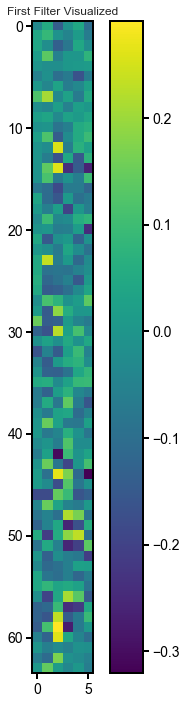

In [35]:
x = small_model_altc.get_weights()
NFILTERS = 10
filters = [x[0][:,:,i] for i in range(NFILTERS)] #layer 1 filters
df_example = pd.DataFrame(data=filters[0])
df_example = df_example.transpose(copy=True)
fig,ax = plt.subplots(figsize=(6,12))
im = ax.imshow(df_example,cmap='viridis') #bp position along the bottom, A/T/G/C along y axis
ax.set_title("First Filter Visualized")
plt.colorbar(im,ax=ax)

In [36]:
min_weight = np.amin(filters)
max_weight = np.amax(filters)
print 'min', min_weight, 'max', max_weight

min -0.5569973 max 0.44855902


How does this look


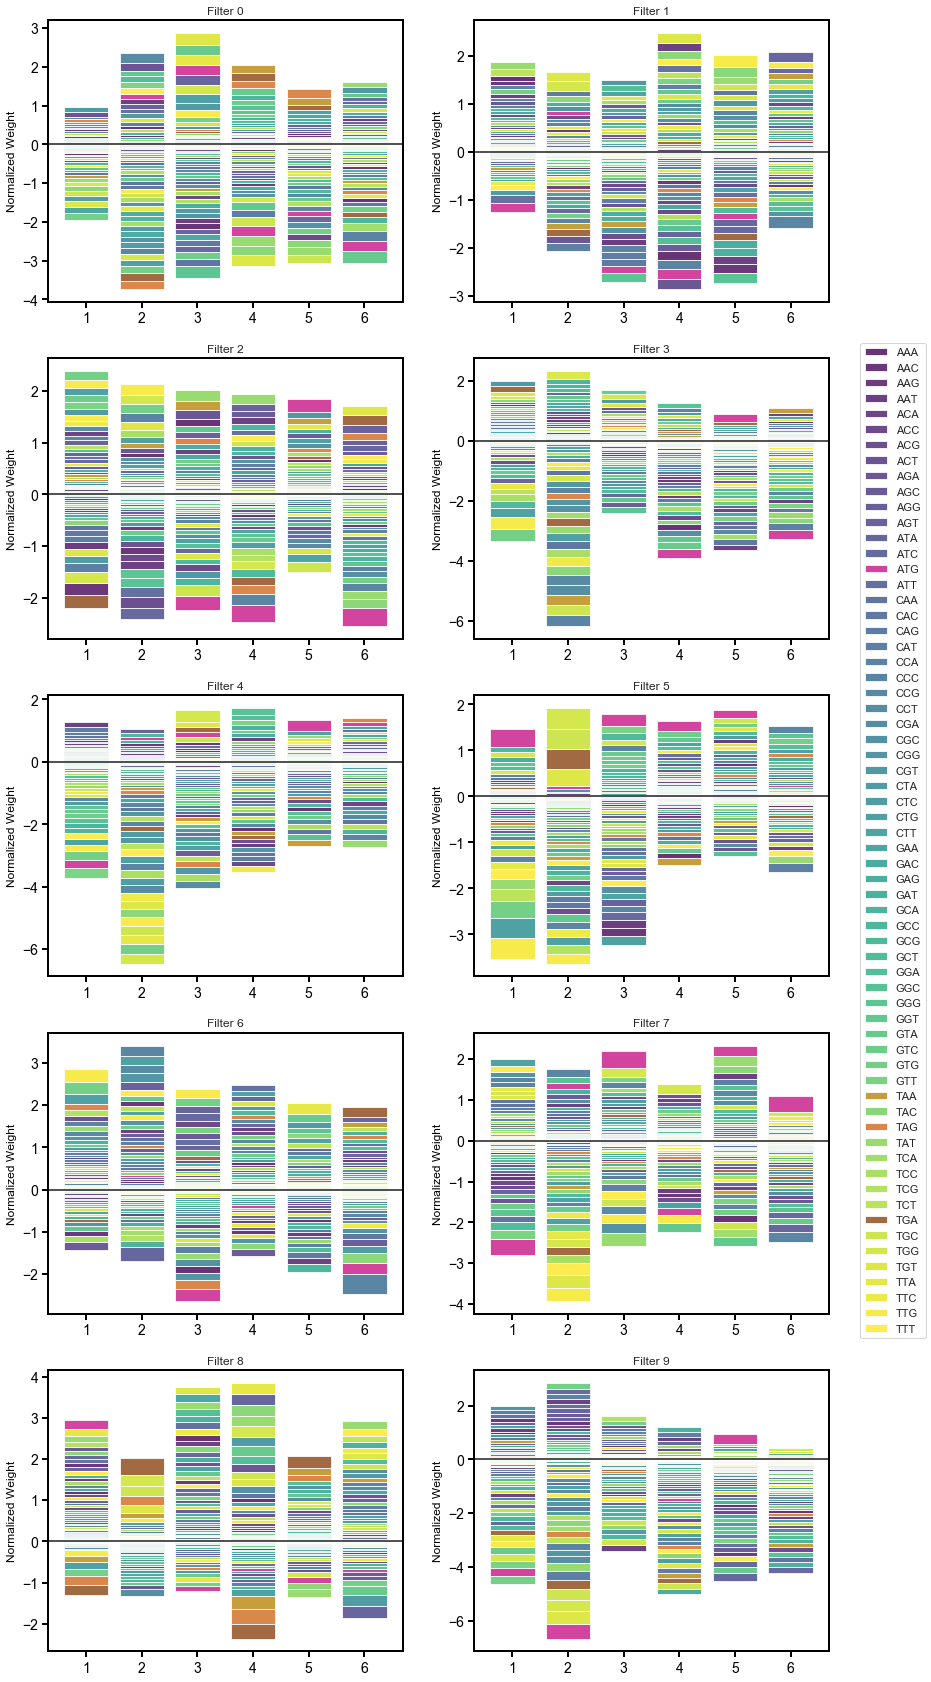

In [37]:
index = np.arange(6) #6 CODON WINDOW, overlapping
fig,axes = plt.subplots(nrows=5,ncols=2,figsize=(14,30)) #TEN FILTERS
for r in range(5):
    for c in range(2):
        i = (r*2) + c
        ax = axes[r][c]
        filterGrid = filters[i].transpose()
        botGrid = compute_stacked_bot_grid(filterGrid)
        # Format so that the negatives and positives don't add together, but stay as independent bars
        for j in range(64):
            v = filterGrid[j]
            b = botGrid[j]
            im = ax.bar(index,v,width=0.8,color=colors[j],label=codon_list[j],bottom=b,alpha=0.8)
        ax.set_xticklabels(['1','2','3','4','5','6'])
        ax.axhline(y=0,color='k')
        ax.set_xticks(np.arange(6))
        ax.set_ylabel("Normalized Weight")
        ax.set_title("Filter "+str(i))
        #ax.set_ylim(-13.01,5.01)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles,labels,loc='right')
print "How does this look"

done


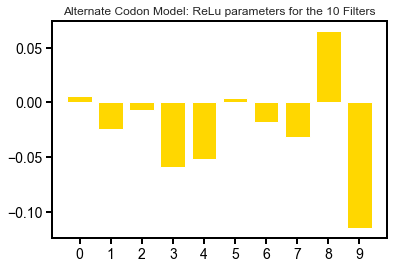

In [38]:
# Which filters have the most negative ReLu Parameters?
plt.bar(range(NFILTERS),x[1],color='gold')
plt.title("Alternate Codon Model: ReLu parameters for the "+str(NFILTERS)+" Filters")
plt.xticks(range(10))
print 'done'

## Question: Do we see relevant negative weighting information that may be being lost in the translation to PWM motifs?

Answer: Yes, in all four encoding strategies we see significant negative weighting, which could be lost in looking purely at frequency matrices (e.g., "NOT-G" would look a lot like even amounts of A/T/C, which would mean little information computed for that position, even if the weighting of NOT-G was really strong.)

## Repeat with Author-Sized Models

In [ ]:
# Load Models
large_model_bp = keras.models.load_model('./saved_models/main_MRL_model.hdf5')
dilated_large_model_bp = keras.models.load.model('./saved/models/dilated_CNN_d4_l1.hdf5')
large_model_orf = keras.models.load_model('./saved_models/120f_orf_CNN_model.hdf5')
large_model_co = keras.models.load_model('./saved_models/120f_codon_CNN_model.hdf5')
large_model_altc = keras.models.load_model('./saved_models/120f_altcodon_CNN_model.hdf5')

In [79]:
# large_model_bp = keras.models.load_model('./saved_models/main_MRL_model.hdf5') #author model

In [40]:
e_test = test_data(df=e_test, model=large_model_bp, obs_col='rl',test_seq=seq_e_test,output_col="120f_bp_pred")
r = r2(e_test['rl'], e_test['120f_bp_pred'])
print 'r-squared = ', r

r-squared =  0.9338504476208073


In [80]:
# large_model_orf = train_model(orf_e_train, label_e_train, nb_epoch=3, border_mode='same',
#                     inp_len=50, inp_features=3, nodes=40, layers=3, nbr_filters=120, filter_len=8,
#                     dropout1=0, dropout2=0, dropout3=0.2)

In [42]:
e_test = test_data(df=e_test, model=large_model_orf, obs_col='rl',test_seq=orf_e_test,output_col="120f_orf_pred")
r = r2(e_test['rl'], e_test['120f_orf_pred'])
print 'r-squared = ', r

r-squared =  0.7536185061617464


In [81]:
# large_model_co = train_model(co_e_train, label_e_train, nb_epoch=3, border_mode='same',
#                     inp_len=16, inp_features=64, nodes=40, layers=3, nbr_filters=120, filter_len=3,
#                     dropout1=0, dropout2=0, dropout3=0.2)

In [44]:
e_test = test_data(df=e_test, model=large_model_co, obs_col='rl',test_seq=co_e_test,output_col="120f_co_pred")
r = r2(e_test['rl'], e_test['120f_co_pred'])
print 'r-squared = ', r

r-squared =  0.8703414308292144


In [82]:
# dilated_large_model_bp =  keras.models.load_model('./saved_models/dilated_CNN_d4_l1.hdf5')

In [46]:
e_test = test_data(df=e_test, 
                   model=dilated_large_model_bp,obs_col='rl',test_seq=seq_e_test,output_col="120f_dilated_bp_pred")
r = r2(e_test['rl'], e_test['120f_dilated_bp_pred'])
print 'r-squared = ', r

r-squared =  0.9205786111098571


In [83]:
# large_model_altc = train_model(altc_e_train, label_e_train, nb_epoch=3, border_mode='same',
#                     inp_len=47, inp_features=64, nodes=40, layers=3, nbr_filters=120, filter_len=3,
#                     dropout1=0, dropout2=0, dropout3=0.2)

In [48]:
e_test = test_data(df=e_test, model=large_model_altc, obs_col='rl',test_seq=altc_e_test,output_col="120f_altc_pred")
r = r2(e_test['rl'], e_test['120f_altc_pred'])
print 'r-squared = ', r

r-squared =  0.9034961476769069


In [84]:
# Save models
# large_model_orf.save('./saved_models/120f_orf_CNN_model.hdf5')
# large_model_co.save('./saved_models/120f_codon_CNN_model.hdf5')
# large_model_altc.save('./saved_models/120f_altcodon_CNN_model.hdf5')

## Visualize Results, Investigate Off-Diagonal Sequences (Are they Shared?)

In [49]:
# Evaluate Performance on Train Dataset, Small Models
# BP Encoding
e_train = test_data(df=e_train, model=small_model_bp, obs_col='rl', test_seq=seq_e_train,output_col='10f_bp_pred')
r = r2(e_train['rl'], e_train['10f_bp_pred'])
print 'BP r-squared = ', r
# ORF Encoding
e_train = test_data(df=e_train, model=small_model_orf, obs_col='rl', test_seq=orf_e_train,output_col='10f_orf_pred')
r = r2(e_train['rl'], e_train['10f_orf_pred'])
print 'ORF r-squared = ', r
# Codon Encoding
e_train = test_data(df=e_train, model=small_model_co, obs_col='rl', test_seq=co_e_train,output_col='10f_co_pred')
r = r2(e_train['rl'], e_train['10f_co_pred'])
print 'Codon r-squared = ', r
# Alternate Codon Encoding
e_train = test_data(df=e_train, model=small_model_altc, obs_col='rl', test_seq=altc_e_train,output_col='10f_altc_pred')
r = r2(e_train['rl'], e_train['10f_altc_pred'])
print 'Alternate Codon r-squared = ', r

BP r-squared =  0.8660732276878229
ORF r-squared =  0.6742547770614378
Codon r-squared =  0.7328999255158205
Alternate Codon r-squared =  0.8574214193907467


In [50]:
# Evaluate Performance on Train Dataset, Large Models
# BP Encoding
e_train = test_data(df=e_train, model=large_model_bp, obs_col='rl', test_seq=seq_e_train,output_col='120f_bp_pred')
r = r2(e_train['rl'], e_train['120f_bp_pred'])
print 'BP r-squared = ', r
# BP Encoding
e_train = test_data(df=e_train,model=dilated_large_model_bp,obs_col='rl',test_seq=seq_e_train,output_col='120f_dilated_bp_pred')
r = r2(e_train['rl'], e_train['120f_dilated_bp_pred'])
print 'Dilated BP r-squared = ', r
# ORF Encoding
e_train = test_data(df=e_train, model=large_model_orf, obs_col='rl', test_seq=orf_e_train,output_col='120f_orf_pred')
r = r2(e_train['rl'], e_train['120f_orf_pred'])
print 'ORF r-squared = ', r
# Codon Encoding
e_train = test_data(df=e_train, model=large_model_co, obs_col='rl', test_seq=co_e_train,output_col='120f_co_pred')
r = r2(e_train['rl'], e_train['120f_co_pred'])
print 'Codon r-squared = ', r
# Alternate Codon Encoding
e_train = test_data(df=e_train, model=large_model_altc, obs_col='rl', test_seq=altc_e_train,output_col='120f_altc_pred')
r = r2(e_train['rl'], e_train['120f_altc_pred'])
print 'Alternate Codon r-squared = ', r

BP r-squared =  0.8941933452903729
Dilated BP r-squared =  0.8833478054721613
ORF r-squared =  0.6749664027153811
Codon r-squared =  0.8356625972808002
Alternate Codon r-squared =  0.8602409060838814


In [51]:
# Make Plotting Function for Reuseability
def jointgrid_plot(datasets,one_dataset=False,colors=[(0.3, 0.45, 0.69),'r'],title="",alphas=[0.1,0.1],
                   xheader='rl',yheader='pred'):
    """
    Make a jointgrid scatter plot of Observed MRL vs Predicted MRL using two or more different datasets 
    colored according to the input list of colors, in a style like the author's figure. 
    If only one dataset, set the flag one_dataset to True so that datasets can be of type list without 
    getting datasets vs dataset elements confused. Bad code but hey.
    """
    data = datasets if one_dataset == True else datasets[0]
    
    g = sns.JointGrid(x=xheader, y=yheader, data=data, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
    g.plot_joint(plt.scatter,s=20, color=colors[0], linewidth=0.2, alpha=str(alphas[0]), edgecolor='white')
    f = g.fig
    ax = f.gca()
    ax.set_yticks(np.arange(0,9.01, 1));
    ax.set_yticklabels(range(10),size=20);
    ax.set_xticks(np.arange(1,10.01, 1));
    ax.set_xticklabels(range(1,11),size=20);
    ax.set_ylim(0,9)
    ax.set_xlim(1,10)
    g.plot_marginals(sns.kdeplot,shade=colors[0], **{'linewidth':2, 'color':colors[0]})
    g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

    if one_dataset == False:
        alphas = alphas if len(alphas) == len(datasets) else [alphas[0]]*len(datasets)
        for d,c,a in zip(datasets[1:],colors[1:],alphas[1:]):
            g.x = d[xheader].values
            g.y = d[yheader].values
            g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha=str(a), color=c, edgecolor='white')
            g.plot_marginals(sns.kdeplot, shade=c, **{'linewidth':2, 'color':c})
            f = g.fig

    f.suptitle(title,fontsize=20)
    
    return f

/usr/local/lib/python2.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


size of off-diagonal cluster, small bp model 1305
size of off-diagonal cluster, large bp model 1244
size of off-diagonal cluster, dilated bp model 1306
Train is blue, Test is red


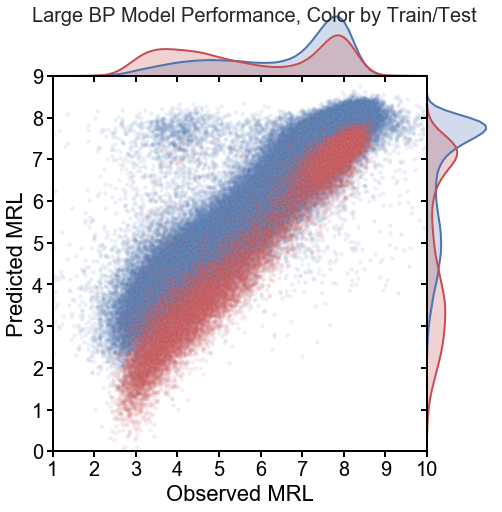

In [52]:
# Visualize Model performance on Test vs Train Datasets
# train_test_plot1 = jointgrid_plot([e_train,e_test],title='Small BP Model Performance, Color by Train/Test',
#                                 yheader='10f_bp_pred')
train_test_plot2 = jointgrid_plot([e_train,e_test],title='Large BP Model Performance, Color by Train/Test',
                                yheader='120f_bp_pred')
# train_test_plot3 = jointgrid_plot([e_train,e_test],title='Dilated Large BP Model Performance, Color by Train/Test',
#                                 yheader='120f_dilated_bp_pred')

small_bp_od = e_train[((e_train['10f_bp_pred']-e_train['rl'])**2 > 3.5)&
                      (e_train['10f_bp_pred']-e_train['rl'] > 0)&
                      (e_train['10f_bp_pred'] > 6.5)] 
large_bp_od = e_train[((e_train['120f_bp_pred']-e_train['rl'])**2 > 3.5)&
                      (e_train['120f_bp_pred']-e_train['rl'] > 0)&
                      (e_train['120f_bp_pred'] > 6.5)] 
dilated_bp_od = e_train[((e_train['120f_dilated_bp_pred']-e_train['rl'])**2 > 3.5)&
                      (e_train['120f_dilated_bp_pred']-e_train['rl'] > 0)&
                      (e_train['120f_dilated_bp_pred'] > 6.5)]

print 'size of off-diagonal cluster, small bp model', len(small_bp_od)
print 'size of off-diagonal cluster, large bp model', len(large_bp_od)
print 'size of off-diagonal cluster, dilated bp model', len(dilated_bp_od)

print "Train is blue, Test is red"

size of off-diagonal cluster, small orf model 5522
size of off-diagonal cluster, large orf model 5693
Train is blue, Test is red


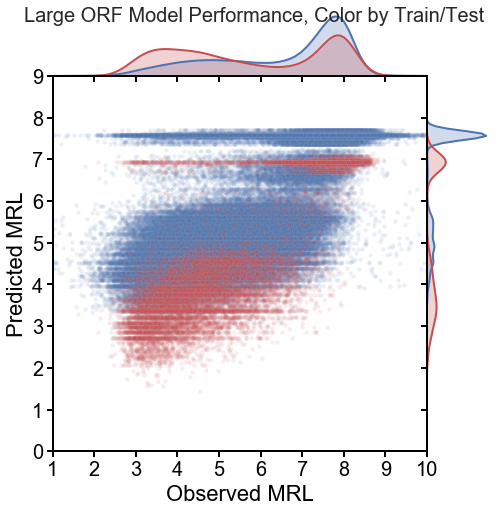

In [53]:
train_test_plot = jointgrid_plot([e_train,e_test],title='Large ORF Model Performance, Color by Train/Test',
                                yheader='120f_orf_pred')

small_orf_od = e_train[((e_train['10f_orf_pred']-e_train['rl'])**2 > 3.5)&
                      (e_train['10f_orf_pred']-e_train['rl'] > 0)&
                      (e_train['10f_orf_pred'] > 6.5)] 
large_orf_od = e_train[((e_train['120f_orf_pred']-e_train['rl'])**2 > 3.5)&
                      (e_train['120f_orf_pred']-e_train['rl'] > 0)&
                      (e_train['120f_orf_pred'] > 6.5)] 

print 'size of off-diagonal cluster, small orf model', len(small_orf_od)
print 'size of off-diagonal cluster, large orf model', len(large_orf_od)

print "Train is blue, Test is red"

size of off-diagonal cluster, small codon model 4362
size of off-diagonal cluster, large codon model 2341
Train is blue, Test is red


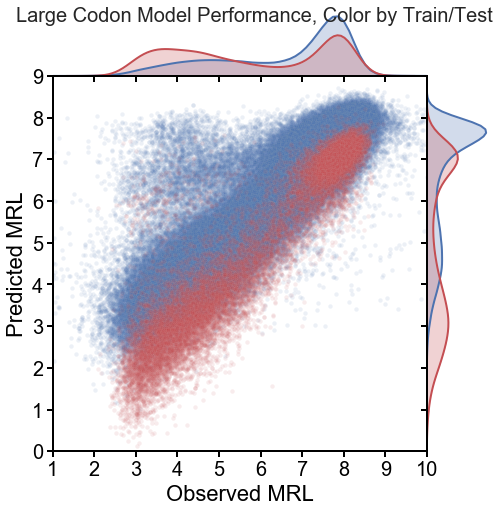

In [54]:
train_test_plot = jointgrid_plot([e_train,e_test],title='Large Codon Model Performance, Color by Train/Test',
                                yheader='120f_co_pred')

small_co_od = e_train[((e_train['10f_co_pred']-e_train['rl'])**2 > 3.5)&
                      (e_train['10f_co_pred']-e_train['rl'] > 0)&
                      (e_train['10f_co_pred'] > 6.5)] 
large_co_od = e_train[((e_train['120f_co_pred']-e_train['rl'])**2 > 3.5)&
                      (e_train['120f_co_pred']-e_train['rl'] > 0)&
                      (e_train['120f_co_pred'] > 6.5)] 

print 'size of off-diagonal cluster, small codon model', len(small_co_od)
print 'size of off-diagonal cluster, large codon model', len(large_co_od)

print "Train is blue, Test is red"

size of off-diagonal cluster, small alt codon model 1539
size of off-diagonal cluster, large alt codon model 1372
Train is blue, Test is red


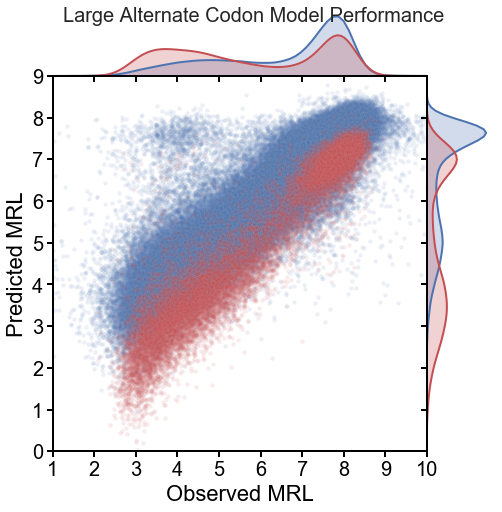

In [55]:
train_test_plot = jointgrid_plot([e_train,e_test],title='Large Alternate Codon Model Performance',
                                yheader='120f_altc_pred')

small_altc_od = e_train[((e_train['10f_altc_pred']-e_train['rl'])**2 > 3.5)&
                      (e_train['10f_altc_pred']-e_train['rl'] > 0)&
                      (e_train['10f_altc_pred'] > 6.5)] 
large_altc_od = e_train[((e_train['120f_altc_pred']-e_train['rl'])**2 > 3.5)&
                      (e_train['120f_altc_pred']-e_train['rl'] > 0)&
                      (e_train['120f_altc_pred'] > 6.5)] 

print 'size of off-diagonal cluster, small alt codon model', len(small_altc_od)
print 'size of off-diagonal cluster, large alt codon model', len(large_altc_od)

print "Train is blue, Test is red"

### How well do the models correlate with each other?

In [ ]:
jointgrid_plot([e_train,e_test],title='BP Model 120f (X) vs Alt Codon Model 120f (Y)',
                                xheader='120f_bp_pred',yheader='120f_altc_pred')
# still colored by train and test

In [56]:
co_shared = set(small_co_od['utr'].values).intersection(set(large_co_od['utr'].values))
print len(small_co_od), len(large_co_od)

len(co_shared)

4362 2341


2012

In [57]:
altc_shared = set(small_altc_od['utr'].values).intersection(set(large_altc_od['utr'].values))
print len(small_altc_od), len(large_altc_od)
len(altc_shared)

1539 1372


1273

In [58]:
codon_shared = co_shared.intersection(altc_shared)
len(codon_shared)

1072

In [59]:
codon_small_shared = set(small_co_od['utr'].values).intersection(set(small_altc_od['utr'].values))
len(codon_small_shared)

1313

In [60]:
bp_shared = set(small_bp_od['utr'].values).intersection(set(large_bp_od['utr'].values))
bp_all_shared = bp_shared.intersection(set(dilated_bp_od['utr'].values))
print len(small_bp_od), len(large_bp_od)
print len(bp_shared)
print len(dilated_bp_od)
len(bp_all_shared)

1305 1244
1187
1306


1163

In [61]:
# how much in common do the off-diagonals have between the two encodings?
bp_codon_shared = set(codon_shared).intersection(bp_all_shared)
print len(bp_codon_shared)
# answer: most of them

976


## Question: what is special about these 987 utrs?

In [62]:
e_test['scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_test['rl'].values.reshape(-1,1))

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [63]:
df = pd.concat([e_train,e_test])
df.head()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,0,1,10,10f_altc_pred,10f_bp_pred,10f_co_pred,10f_orf_pred,11,12,120f_altc_pred,...,r5,r6,r7,r8,r9,rl,scaled_rl,total,total_reads,utr
20000,0.000009,0.000009,0.000005,4.971714,4.781784,4.972458,4.707952,0.000005,0.000006,4.825760,...,0.078944,0.050675,0.032874,0.032978,0.035288,5.049107,-0.940608,0.000098,2497.0,CCGGCTATAGCGCGCAGTGCTCGGATGGCAAGGCGTTCAACCGTGACCAC
20001,0.000017,0.000015,0.000004,4.602307,4.389086,4.792544,4.767494,0.000004,0.000003,4.581498,...,0.046041,0.036403,0.036747,0.023606,0.025795,3.944024,-1.641174,0.000095,2497.0,AATGGGTACCGTATGTCAAAGGAACCATAGGCGCGGTCGTAGTGGACTCA
20002,0.000011,0.000013,0.000004,3.257403,4.128348,3.843840,4.462711,0.000004,0.000004,4.143399,...,0.066356,0.042655,0.033259,0.028520,0.033749,4.665749,-1.183637,0.000098,2497.0,CCGCGGCATGATCAAACGGTCTAGATCATAATGCGAGGTCAGTACCACTA
20003,0.000014,0.000018,0.000003,4.444797,4.070875,4.253957,4.797128,0.000003,0.000002,4.394584,...,0.062284,0.026093,0.027523,0.032716,0.037834,3.787840,-1.740187,0.000096,2497.0,GTGTAAGGCTCTGGTGGGCACACGTCGGTTTGCAGTAATGACAGACACGT
20004,0.000001,0.000002,0.000011,8.011770,7.908609,7.950617,7.571603,0.000011,0.000010,7.914568,...,0.067340,0.078520,0.104213,0.106370,0.093410,8.059969,0.968125,0.000103,2497.0,CCGGAAAATCGCGCAAGTCTCCCTTACGAATAAAGCTCAAAGGGAACGTC


In [64]:
df['is_bp_codon_shared_od'] = df['utr'].apply(lambda s: s in bp_codon_shared)

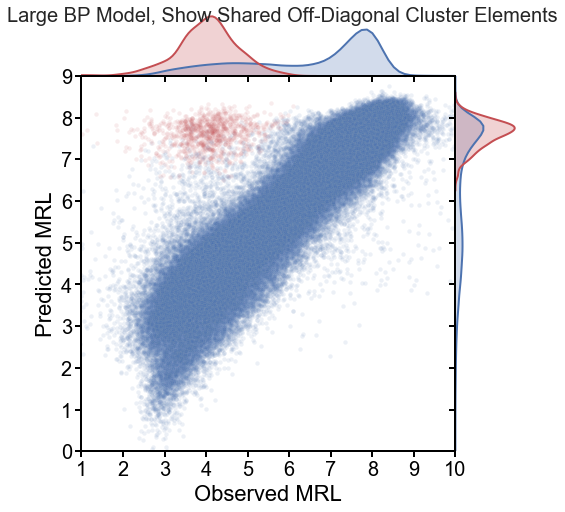

In [65]:
a = df[df['is_bp_codon_shared_od'] == True] 
b = df[df['is_bp_codon_shared_od'] == False]
shared_plot = jointgrid_plot([b,a],title='Large BP Model, Show Shared Off-Diagonal Cluster Elements',
                                yheader='120f_bp_pred')


## What Does the Polysome Data Look like for these UTRs vs others?

the polysome data is stored in read 0  through read 14 in the original data set (RL is the MRL, but the others are part of the polysome fractions; the array of r0 - r14 gives the polysome graph

In [66]:
rfractions = ['r' + str(x) for x in range(14)]

143170 59686


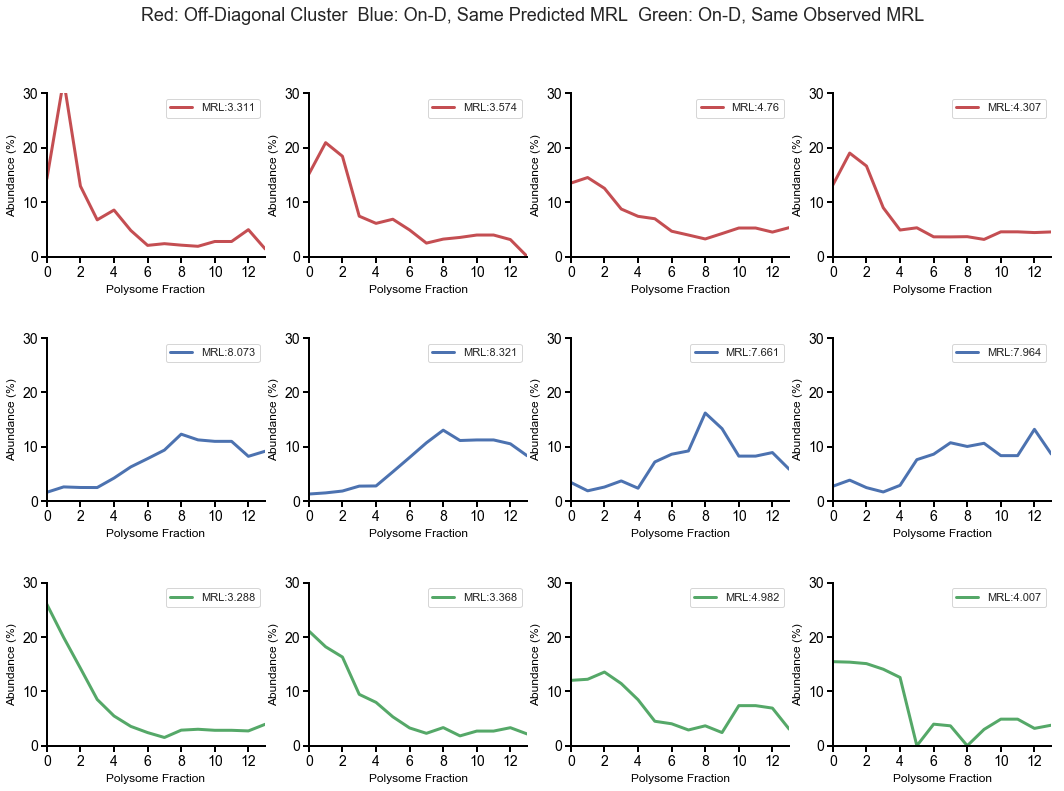

In [113]:
# Graphing
np.random.seed(1337)
from matplotlib import ticker
NSHOW = 4
current_palette = sns.color_palette()
f, axes = plt.subplots(nrows=3,ncols=NSHOW,figsize=(18,12))
f.subplots_adjust(hspace=0.5)
f.suptitle("Red: Off-Diagonal Cluster  Blue: On-D, Same Predicted MRL  Green: On-D, Same Observed MRL",fontsize=18)  


comparison_set_1 = b[(b['rl'] > 7) & (b['rl'] < 8.5)] 
comparison_set_2 = b[(b['rl'] > 3) & (b['rl'] < 5)]
print len(comparison_set_1), len(comparison_set_2)

comp1_subset_inds = np.random.choice(range(len(comparison_set_1)),NSHOW)
comp1 = comparison_set_1.iloc[comp1_subset_inds][rfractions].values * 100
comp1_utrs = comparison_set_1.iloc[comp1_subset_inds]['utr'].values
comp1_mrls = comparison_set_1.iloc[comp1_subset_inds]['rl'].values

comp2_subset_inds = np.random.choice(range(len(comparison_set_2)),NSHOW)
comp2 = comparison_set_2.iloc[comp2_subset_inds][rfractions].values * 100
comp2_utrs = comparison_set_2.iloc[comp2_subset_inds]['utr'].values
comp2_mrls = comparison_set_2.iloc[comp2_subset_inds]['rl'].values

od_subset_inds = np.random.choice(range(len(a)),NSHOW)
ods = a.iloc[od_subset_inds][rfractions].values * 100
od_utrs = a.iloc[od_subset_inds]['utr'].values
od_mrls = a.iloc[od_subset_inds]['rl'].values

majorLocator = ticker.MultipleLocator(2)

for row in range(3):
    for col in range(NSHOW):
        i = col + (row*NSHOW)
        ax = axes[row][col]
        if row == 0:
            ax.plot(ods[col],color='r',linewidth=3,label="MRL:"+str(np.round(od_mrls[col],3)))
        elif row == 1:
            ax.plot(comp1[col],color='b',linewidth=3,label="MRL:"+str(np.round(comp1_mrls[col],3)))
        else:
            ax.plot(comp2[col],color='g',linewidth=3,label="MRL:"+str(np.round(comp2_mrls[col],3)))
        ax.xaxis.set_major_locator(majorLocator)
        ax.tick_params(axis='both', pad=3)
        ax.set_ylabel('Abundance (%)')
        ax.set_xlabel('Polysome Fraction')
        ax.set_xlim(0,13)
        ax.set_ylim(0,30)
        ax.legend()
sns.despine()